<a href="https://colab.research.google.com/github/Desliny/EI_ST4/blob/FLORIAN/Notebook_jour_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Information Retrieval
## Introduction to search engines

### DAY 2: Teacher version
### Implementing a search engine

The goal of this second session is to implement a first architecture of a search engine on the previously introduced dataset (stackexchange-datascience). If you missed the first session or if you did not saved the dataset, please reload the first session's notebook to download it. 

If you need some ifnormation about the dataset, it should be available here : https://archive.org/details/stackexchange

The notebook is divided into several steps:
-	Implement the indexation
-	Implement the search method
-	Define a ranking strategy and implement it
-	Suggest some improvements of the search engine



## Initialisation

In [1]:
!pip install ttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ttable: filename=ttable-0.6.4-cp310-cp310-linux_x86_64.whl size=212631 sha256=80d61d750c0cbf8615406409d89891289915f3d4d6bbea9412393ece132435e6
  Stored in directory: /root/.cache/pip/wheels/0d/8d/56/f2572fdbf1ef1f8a947d7ff25ce18d9373d8e02a68f9ac8de6
Successfully built ttable


In [2]:
import pandas as pd
import re
import os
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from tt import BooleanExpression
from itertools import product
import numpy as np

In [3]:
# Only if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# TODO:
DATA_PATH = '/content/drive/MyDrive/EI/data' 


**Important :**

An Excel file for testing the evaluation part is available in the gitlab repo : evaluation_search_engine_post_queries_ranking_EI_CS.xlsx

If you work on Colab, we advice you to push it directly on your Google Drive directory.

# Implement the indexation
As you might already know, for a search engine to work properly an index of the documents must be created. Here we will keep it in python, and try to use only common libraries to keep it simple.

Once created, the index will be used to match the query with the documents. As a result, there are several ways to build an index, using statistical, boolean, semantic indexation...

First of, let's make a naive one that will consist in breaking down each document into a set of the words it contains.

In [5]:
def extract_words(text:str)->list:
  L = text.split()
  return set(L)

In [6]:

# test
s = "The cat is sat on the mat. The dog is laid on the mat."
L1=extract_words(s)
L2=set(["The","cat","is","sat","on","the","mat.","dog","laid"])
assert L1==L2

As you may notice, there are several problems with the previous implementation. First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 

Re-implement this function with some basic preprocessing to avoid these issues.

In [71]:
def standard(mot):
  res=""
  for x in mot:
    if x not in [' ', ',', '.', ';', '?', '!', '"', "(", ")", "'"]:
      res+=x
  return res.lower()

def extract_words(text:str)->list:
  L = text.split()
  L = [standard(mot) for mot in L]
  return L

In [69]:
# test
L1=set(extract_words(s))
L2=set(["the","cat","is","sat","on","mat","dog","laid"])
assert L1==L2

Now you sould be able to create your index table. For now we will just make a dataframe with two columns: [raw_text, words].

In [72]:
import pandas as pd

def index_docs(docs:list[str])->pd.DataFrame:
  L=[docs,[extract_words(doc) for doc in docs]]
  return pd.DataFrame(L)

In [73]:
# test

L = [s, "Hello World!", "Goodbye", "How are you?"]

index_docs(L)

,0,1,2,3
0,The cat is sat on the mat. The dog is laid on ...,Hello World!,Goodbye,How are you?
1,"[the, cat, is, sat, on, the, mat, the, dog, is...","[hello, world]",[goodbye],"[how, are, you]"


Now, let's try it on the dataset:

In [11]:
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014-05-13T23:58:30.457,9,898.0,<p>I've always been interested in machine lear...,5.0,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,...,2014-05-14T14:40:25.950,CC BY-SA 3.0,NaN,NaN,None,NaN,None,None,None,NaN
1,7,1,2014-05-14T00:11:06.457,4,478.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,...,2014-05-14T08:40:54.950,CC BY-SA 3.0,10.0,97.0,2014-05-16T13:45:00.237,NaN,None,None,None,NaN
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014-05-14T00:36:31.077,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,5.0,None,None,None,NaN
3,10,2,2014-05-14T00:53:43.273,13,NaN,"<p>One book that's freely available is ""The El...",22.0,2014-05-14T00:53:43.273,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,7.0,None,None,None,NaN
4,14,1,2014-05-14T01:25:59.677,26,1901.0,<p>I am sure data science as will be discussed...,66.0,2020-08-16T13:01:33.543,Is Data Science the Same as Data Mining?,<data-mining><definitions>,...,None,CC BY-SA 3.0,29.0,322.0,2014-06-17T16:17:20.473,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75722,119962,1,2023-03-04T20:06:06.820,0,8.0,<p>I am implementing a neural network of arbit...,147597.0,2023-03-04T20:22:12.523,Back Propagation on arbitrary depth network wi...,<neural-network><backpropagation>,...,None,CC BY-SA 4.0,NaN,147597.0,2023-03-04T20:22:12.523,NaN,None,None,None,NaN
75723,119963,1,2023-03-04T20:12:19.677,0,10.0,<p>I am using KNN for a regression task</p>\n<...,147598.0,2023-03-04T20:12:19.677,Evaluation parameter in knn,<regression><k-nn>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75724,119964,1,2023-03-05T00:14:12.597,0,7.0,<p>I have developed a small encoding algorithm...,44581.0,2023-03-05T00:14:12.597,Can I use zero-padded input and output layers ...,<deep-learning><convolutional-neural-network>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75725,119965,1,2023-03-05T00:43:12.213,0,5.0,"<p>To my understanding, optimizing a model wit...",84437.0,2023-03-05T00:43:12.213,Why does cross validation and hyperparameter t...,<cross-validation><hyperparameter-tuning>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN


For our first version of the indexation mechanism, we will simply use the "body" of the posts. To have a better search engine, the title and other metadata aswell could be used aswell. Finally, not all the XML files have a "body" feature, so for the search engine to retrieve information from any of the files you will need to implement another way to index.

But first, let's start with "body". There is more to preprocess than before, indeed, there are html tags such as "<p>" for instance. They are not useful for us, because users won't use them in their queries. So we first need to remove them.

In [12]:
def remove_tags(text:str)->str:
  res=""
  in_tag=False
  next=False
  for lettre in text:
    if lettre=='<' and not in_tag:
      in_tag=True
    elif lettre=='>' and in_tag:
      in_tag=False
    elif lettre=='\n' or lettre=='\t':
      next=True
    elif not in_tag:
      if next:
        res+=" " + str(lettre)
        next=False
      else:
        res+=str(lettre)
  return res

In [13]:
# test
remove_tags('<p>Hello World!\nI am making a search engine.<p>')

'Hello World! I am making a search engine.'

In [14]:
clean_posts = posts[['Id','Body']]
clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts

<ipython-input-14-2f3e0e9b59ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)


,Id,Body,Clean Body
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...
...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task It's like...
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k..."


In [75]:
def extract_words2(text):
  L=extract_words(text)
  L=remove_stop_words(L)
  return L

clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words2)
clean_posts

<ipython-input-75-666a87a5cf14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words2)


,Id,Body,Clean Body,words
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...,"[ive, always, interested, machine, learning, c..."
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo...","[researcher, instructor, im, looking, open-sou..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu...","[sure, fits, scope, se, heres, stab, answer, a..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme...","[one, book, thats, freely, available, elements..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...,"[sure, data, science, discussed, forum, severa..."
...,...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...,"[implementing, neural, network, arbitrary, dep..."
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task It's like...,"[using, knn, regression, task, like, that:, 1-..."
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...,"[developed, small, encoding, algorithm, accept..."
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k...","[understanding, optimizing, model, k-fold, cro..."


## Zipf Law

A way of analyzing a corpus is to draw the zipf law

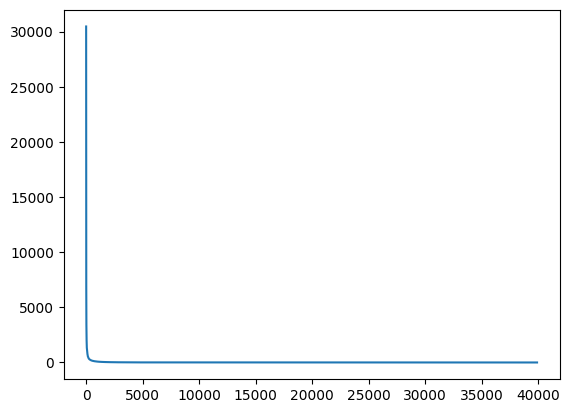

In [76]:
# TODO : Draw Zipf Law on the Posts Corpus
import matplotlib.pyplot as plt

zipf = sorted(inverted_index.items(), key=lambda kv: -kv[1])
L_Y=[]
for _,x in zipf:
  L_Y.append(x)
L_X = [k for k in range(1,len(L_Y)+1)]

plt.plot(L_X,L_Y)
plt.show()

## Inverted Index

Now, we want to go further on the indexing and build an inverted index. Inverted index is a dictionary where the keys are the words of the vocabulary and the values are the documents containing these words. Reducing the size of the vocabulary is a relevant first step when building an inverted index. Here, we will focus on the creation of the index, we leave you the optimisation steps :)

In [91]:
def create_index(posts:pd.DataFrame)-> dict:
  L_words=posts['words']
  n=len(L_words)
  res={}
  for k in range(n):
    for word in L_words[k]:
      if word in res:
        res[word].add(posts["Id"][k])
      else:
        res[word]={posts["Id"][k]}
  return res

In [92]:
inverted_index = create_index(clean_posts.iloc[0:5000])
inverted_index

{'ive': {5,
  41,
  140,
  172,
  205,
  226,
  302,
  310,
  319,
  334,
  358,
  371,
  382,
  400,
  406,
  411,
  412,
  436,
  441,
  471,
  492,
  498,
  499,
  503,
  504,
  527,
  545,
  564,
  641,
  668,
  671,
  754,
  802,
  806,
  818,
  819,
  820,
  825,
  840,
  869,
  881,
  946,
  948,
  992,
  1013,
  1024,
  1048,
  1060,
  1105,
  1176,
  1177,
  1185,
  1194,
  1197,
  1205,
  1214,
  1246,
  1249,
  1250,
  2258,
  2298,
  2317,
  2338,
  2339,
  2344,
  2349,
  2362,
  2384,
  2411,
  2420,
  2431,
  2446,
  2447,
  2454,
  2570,
  2596,
  2616,
  2624,
  2630,
  3705,
  3738,
  3741,
  3742,
  3754,
  3763,
  3770,
  3771,
  3779,
  3792,
  3818,
  4833,
  4843,
  4845,
  4846,
  4880,
  4900,
  4915,
  4916,
  4927,
  4946,
  4985,
  4988,
  4992,
  5021,
  5037,
  5038,
  5050,
  5055,
  5060,
  5062,
  5108,
  5122,
  5161,
  5178,
  5186,
  5212,
  5224,
  5243,
  5267,
  5281,
  5302,
  5331,
  5357,
  5365,
  5367,
  5368,
  5371,
  5389,
  5409,
  5413,


#### Well Done, you've indexed the dataset! 
Don't hesitate to save your indexes in txt or pickle file

---
# Implement the search method

A naive method would be to count the number of words in common between the query and each posts. Then to rank the posts you could directly select the post who maximize the number of common words. Let's implement this approach :

In [81]:
# Implement the word_in_index function 
# Inputs : a word (str) & a list of words
# Output : pandas series of 1 if the word is in the list, else 0

def word_in_index(word, word_list_index):
  # TODO
  res = [1 if word==x else 0 for x in word_list_index]
  return pd.Series(res)

In [82]:
# Implement the function which run through a pandas series and count the number of word in common
# Use extract_words method, apply method with word_in_index function
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query, word_serie):
  # TODO
  res=[]
  query_words = extract_words(query)
  for doc in word_serie:
    cp=0
    for word in query_words:
      cp+=count(word, doc)
    res.append(cp)
  return pd.Series(res)

def count(word, word_serie):
  L=word_in_index(word, word_serie)
  res=0
  for x in L:
    res+=x
  return res

In [83]:
def rank_top_query(query, df, top=5):
  # TODO
  L=df["words"]
  count = count_common_words(query, pd.Series(L))
  count.sort_values(ascending=False, inplace=True)
  indices = count.index[:top]
  return indices

In [84]:
rank_top_query(query="testing the query in python", df=clean_posts, top=5)

<ipython-input-81-0bd32c9e3c2c>:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(res)


Int64Index([5759, 298, 8808, 69730, 60203], dtype='int64')

Testez plusieurs requêtes et critiquez les résultats obtenus.

Quels sont les pros and cons de cette méthodes. Vous l'indiquerez sur le rapport avec vos réflexions pour l'améliorer.

Next, you have to implement the first improvements you find in the search method to get most relevant results 

In [85]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stop_words(l_txt: list) -> list:
  # TODO
  res=[]
  for x in l_txt:
    if x not in stop_words:
      res.append(x)
  return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Boolean Search

Thanks to the ttable library, implement a boolean search method

In [228]:
import tt

def get_line(L):
  L.reverse()
  res=0
  last=1
  for x in L:
    if x:
      res+=last
    last*=2
  return res 

def boolean_search(query):
  # TODO
  res = []
  table = tt.TruthTable(query)
  symbols = query.symbols
  n=len(clean_posts)
  for k in range(n):
    L_words=clean_posts["words"][k]
    boolean=[standard(symbol) in L_words for symbol in symbols]
    i=get_line(boolean)
    if table[i]:
      res.append(clean_posts["Id"][k]) 
  return set(res)

In [269]:
def union(set1,set2):
  return set1.union(set2)

def intersect(set1, set2):
  return set1.intersection(set2)

def exclude(set1,set2):
  return set1.difference(set2)

def get(symbols,k):
  n=len(symbols)
  eval=bin(k)[2:]
  res = {index for index in clean_posts["Id"]}
  m=len(eval)
  for _ in range(n-m):
    eval="0"+eval
  for i in range(n):
    if standard(symbols[i]) in inverted_index:
      if eval[i]=="1": 
        res=intersect(res,inverted_index[standard(symbols[i])])
      else:
        res=exclude(res,inverted_index[standard(symbols[i])])
    else:
      if eval[i]=="1":
        return {}
  return res



def boolean_search2(query):
  table = tt.TruthTable(query)
  symbols = query.symbols
  n=2**len(symbols)
  res=set([])
  for k in range(n):
    if table[k]:
      res=union(res,get(symbols,k))
  return res


In [270]:
query='Always and not been and not interested'
bool_query=BooleanExpression(query)
print(tt.TruthTable(bool_query))

+--------+------+------------+---+
| Always | been | interested |   |
+--------+------+------------+---+
|   0    |  0   |     0      | 0 |
+--------+------+------------+---+
|   0    |  0   |     1      | 0 |
+--------+------+------------+---+
|   0    |  1   |     0      | 0 |
+--------+------+------------+---+
|   0    |  1   |     1      | 0 |
+--------+------+------------+---+
|   1    |  0   |     0      | 1 |
+--------+------+------------+---+
|   1    |  0   |     1      | 0 |
+--------+------+------------+---+
|   1    |  1   |     0      | 0 |
+--------+------+------------+---+
|   1    |  1   |     1      | 0 |
+--------+------+------------+---+


In [271]:
exclude(boolean_search(bool_query),boolean_search2(bool_query))
32768 in inverted_index[standard("always")]

False

In [246]:
clean_posts[clean_posts["Id"]==32768]["Clean Body"]

21089    For tree-based algorithms, it depends on the a...
Name: Clean Body, dtype: object

## Probabilistic search

Implement the MIB or BM25 method of searching

In [28]:
!pip install rank_bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from rank_bm25 import BM25Okapi

def probabilistic_search(query):
  tokenized_corpus=[L for L in clean_posts["words"]]
  bm25 = BM25Okapi(tokenized_corpus)
  tokenized_query = extract_words(query)
  posts=clean_posts[["Id","Clean Body"]]
  n=len(clean_posts)
  index={posts["Clean Body"][k]:posts["Id"][k] for k in range(n)}
  res=[]
  for body in bm25.get_top_n(tokenized_query, clean_posts["Clean Body"], n=5):
    res.append(index[body])
  return res

In [65]:
probabilistic_search("Test de la query proba")

[116441, 6805, 49560, 54491, 104611]

Compare the naive method with your improvements and the boolean and probabilistic search. (report)



---



---




# Evaluate the Search

Now you implement multiple search methods and you're able to improve it. You have to define metric to compare it objectively.



We ask you to implement NDCG (Normalized Discounted Cumulative Gain) from few queries we implement on a dozen of post. We already defined the values of relevance judgement in the xlsx file : . The final score will be the mean quadratic error of the queries.


Explication for the xlsx file :

We propose you a Excel file with some posts and a mesure of relevancy for the queries

- First column is the post Id,
- Columns starting by query are the queries you have to test.
- The values in this columns are the rank of relevancy of the post in regard with the query.
- The missing values indicates you should not take into account the post


You will have to criticize this metric and your result in the report. Then you will have to propose some improvements. 

Thereafter in this week, you will have to compare your different search engines.

In [ ]:
# Read Relevancy CSV
df_relevancy = pd.read_excel("/content/drive/MyDrive/TP Centrale/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")

In [ ]:
def calculate_ndgc(query_col="query", output_col="query_output"):
  # TODO

  return

